In [1]:
import gym
from gym import spaces
import numpy as np
import heuristicBot
import TicTacToe as ttt
import os

Player representation : 1(X), 2(O)
Game grid : a 3x3 numpy array

In [2]:
def mark_piece(grid, index, player):
    """
    1. places a move by the RL agent
    2. check if invalid
    3. if not check if agent won or draw
    4. if not place move by opponent
    5. check if opponent won or draw
    6. return respective code at appropiate step
    returns -2:continue, -1:invalid move, 
            1:1 wins, 2:2 wins, 0:draw
    """
    if grid[index] != 0:
        return -1, grid
    else:
        grid[index] = player
        score = ttt.gridScore(grid)
        if score != -1 and score == 1:
            return player, grid
        elif score != -1:
            return 0, grid
        # opponent agent : a n-step-lookahead bot
        available_moves = [(i, j) for i in range(3)
                           for j in range(3) if grid[i, j] == 0]
        opp_player = (player % 2) + 1
        opp_move_idx = heuristicBot.nslAgent(
            2, grid, available_moves, opp_player)
        grid[opp_move_idx] = opp_player
        score = ttt.gridScore(grid)
        if score != -1 and score == 1:
            return opp_player, grid
        elif score != -1:
            return 0, grid
        return -2, grid

# Defining the Custom gym environment
**Rewards**
- 1 for winning
- -1 for loosing
- -10 for invalid move
- 1/9 for everything else

In [3]:
class TicTacToeEnv(gym.Env):
    def __init__(self):
        """
        Define action and observation space
        They must be gym.spaces objects
        """
        super(TicTacToeEnv, self).__init__()
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low=0, high=2, shape=(3,3), dtype=int)
        self.reward_range = (-10, 1)
        self.action_moves = [(i,j) for i in range(3) for j in range(3)]
        self.player = 1
        
        # defined else stable baselines throws error
        self.spec = None
        self.metadata = None


    def reset(self):
        """
        Reset the state of the environment to an initial state
        returns 
        eg.
            return self.state
        """
        self.grid = np.zeros((3, 3))

        return self.grid


    def step(self, action):
        """
        Execute one time step within the environment
        returns next state
        eg. 
            modify state
            return self.state, reward, done, info
        """
        score, self.grid = mark_piece(self.grid, self.action_moves[action], self.player)

        # reward
        reward = 0
        if score == -1:
            reward = -10
        elif score == 1:
            reward = 1
        elif score == 2:
            reward = -1
        elif score == -2:
            reward = 1/9

        # check if grid ended
        done = True
        if score == -2:
            done = False

        # info for debugginh
        info = {}
        
        return self.grid, reward, done, info


    def render(self):
        if ttt.gameOver(self.grid, self.player, False)[0]:
            print('-----------------')
            ttt.showGrid(self.grid)
            print('-----------------')


# Test environment

In [6]:
env = TicTacToeEnv()
episodes = 5
for episode in range(episodes):
    obs = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = env.action_space.sample()
        obs, reward, done, infp = env.step(action)
        score += reward
    print(f'Episode:{episode+1}, Score:{score}')
env.close()

Episode:1, Score:-9.777777777777779
Episode:2, Score:-0.7777777777777778
Episode:3, Score:-0.7777777777777778
Episode:4, Score:-9.666666666666666
Episode:5, Score:-9.777777777777779


In [7]:
from stable_baselines.bench import Monitor
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2

In [8]:
# logging training information
log_dir = 'training_logs_MlpPolicy/'
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

In [9]:
# using a predefined model
env = TicTacToeEnv()
pre_model = PPO2(MlpPolicy, vec_env, verbose=1)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [ ]:
pre_model.learn(total_timesteps=30000)

# Test the model and save

In [98]:
from stable_baselines.common.evaluation import evaluate_policy

In [99]:
evaluate_policy(pre_model, env, n_eval_episodes=10, render=True)
env.close()

-----------------
| X || O || X |
| _ || O || X |
| _ || O || _ |
-----------------
-----------------
| X || O || X |
| _ || X || _ |
| O || O || X |
-----------------
-----------------
| X || O || X |
| X || O || _ |
| X || _ || O |
-----------------
-----------------
| X || O || X |
| _ || O || X |
| O || _ || X |
-----------------
-----------------
| X || O || X |
| O || X || _ |
| X || _ || O |
-----------------
-----------------
| X || O || X |
| _ || X || _ |
| O || O || X |
-----------------
-----------------
| O || X || X |
| _ || X || O |
| O || X || _ |
-----------------
-----------------
| X || O || X |
| X || O || _ |
| X || _ || O |
-----------------
-----------------
| X || O || X |
| X || O || _ |
| X || _ || O |
-----------------
-----------------
| X || X || X |
| O || O || _ |
| X || _ || O |
-----------------


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

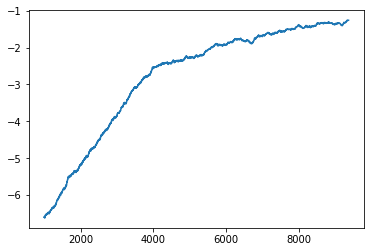

In [111]:
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

# Save the model

In [102]:
pre_model.save('PPO2_model')
del pre_model

In [104]:
pre_model = PPO2.load("PPO2_model", env=vec_env)

In [107]:
obs = env.reset()
while True:
    action, _states = pre_model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
        break
env.close()

-----------------
| O || X || X |
| _ || X || O |
| O || X || _ |
-----------------
